In [4]:
import tensorflow as tf
import numpy as np 
import tensorflow.contrib.slim as slim
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/home/ubuntu/workspace/models/slim")
from datasets import dataset_utils

#### tutorial link: https://github.com/warmspringwinds/tensorflow_notes

##### 1. download vgg-16 model 
we will use for classification of images and segmentation

In [5]:
url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
checkpoints_dir = './checkpoints'
if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)
    dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)


>> Downloading vgg_16_2016_08_28.tar.gz 100.0%
Successfully downloaded vgg_16_2016_08_28.tar.gz 513324920 bytes.


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import urllib
from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

##### 2. Get Vgg output layer, load weights 

In [7]:
tf.reset_default_graph()
image_size = vgg.vgg_16.default_image_size
checkpoints_dir = './checkpoints'

image = tf.placeholder(tf.float32)

# The crop will be of the size of the default image size of the network.
processed_image = vgg_preprocessing.preprocess_image(image,
                                                     image_size,
                                                     image_size,
                                                     is_training=False)
# Networks accept images in batches.
# The first dimension usually represents the batch size.
# In our case the batch size is one.
processed_images  = tf.expand_dims(processed_image, 0)

# Create the model, use the default arg scope to configure
# the batch norm parameters. arg_scope is a very conveniet
# feature of slim library -- you can define default
# parameters for layers -- like stride, padding etc.
with slim.arg_scope(vgg.vgg_arg_scope()):
    logits, _ = vgg.vgg_16(processed_images,
                           num_classes=1000,
                           is_training=False)
    ### the returned items for vgg_16 is (net,end_pint), net is the built out structure, end_point shoud b ethe probility
    ### logits is a (1,1000) tensor
    
# In order to get probabilities we apply softmax on the output.
probabilities = tf.nn.softmax(logits)
### probabilities is a (1,1000) tensor

# Create a function that reads the network weights
# from the checkpoint file that you downloaded.
# We will run it in session later.
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
    slim.get_model_variables('vgg_16'))

##### 3. define run session 

In [10]:
def run_predection(test_image,processed_image,probabilities):
    with tf.Session() as sess:
        # Load weights
        init_fn(sess)
        # We want to get predictions, image as numpy matrix
        # and resized and cropped piece that is actually
        # being fed to the network.
        network_input, prob = sess.run([processed_image,probabilities],feed_dict={image:test_image})

        prob = prob[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-prob),
                                        key=lambda x:x[1])]
    
    return (sorted_inds[:5],prob[sorted_inds[:5]])

#### 4.predict

In [11]:
import matplotlib.image as mpimg
test_image = mpimg.imread('test_data/image_test.jpg')
index, prob = run_predection(test_image,processed_image,probabilities)

Probability 0.78 => [Indian elephant, Elephas maximus]
Probability 0.18 => [black swan, Cygnus atratus]
Probability 0.03 => [indri, indris, Indri indri, Indri brevicaudatus]
Probability 0.00 => [American alligator, Alligator mississipiensis]
Probability 0.00 => [African chameleon, Chamaeleo chamaeleon]


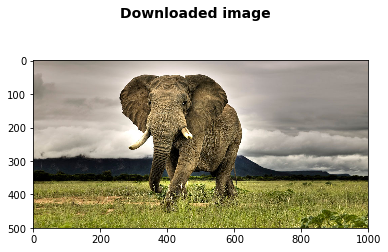

In [12]:
plt.suptitle("Downloaded image", fontsize=14, fontweight='bold')
plt.imshow(test_image)

names = imagenet.create_readable_names_for_imagenet_labels()
for i in range(5):
    print('Probability %0.2f => [%s]' % (prob[i], names[index[i]]))

###  Image Annotation and Segmentation

Below we will see a simple example of Segmentation. For the simplicity, the segmentation will be of a smaller size than the original image. We can do segmentation using an existing Convolutional Neural Network by applying it in a Fully Convolutional manner. This is done by casting the Fully Connected Layers of a network into Convolutional -- this way we can input image of any size and get segmentation of lower resolution due to max-pooling layers that are used in network. To get the Segmentation of the same size as an input, deconvolutional layers can be used. You can read more about this in the paper fully convolutional networks for semantic segmentation by Long et al. We won't consider deconvolutional layers in this example. Example below shows how to get segmentation of lower resolution than the input. Deconvolutional layers can be seen as a way to perform interpolation. Interpolation can be different (quadratic, qubic and other) but network can learn a specific interpolation that performs well under a certain task.

In [13]:
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

In [14]:
# Function to nicely print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):
    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,
                      cmap=cmap,
                      vmin = np.min(data)-.5,
                      vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)
    
    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold')

In [34]:
tf.reset_default_graph()
checkpoints_dir = './checkpoints'

image = tf.placeholder(tf.float32,[None,None,3])
# Convert image to float32 before subtracting the
# mean pixel value
image_float = tf.to_float(image, name='ToFloat')

# Subtract the mean pixel value from each pixel
processed_image = _mean_image_subtraction(image_float,
                                          [_R_MEAN, _G_MEAN, _B_MEAN])

input_image = tf.expand_dims(processed_image, 0)

with slim.arg_scope(vgg.vgg_arg_scope()):
    # spatial_squeeze option enables to use network in a fully
    # convolutional manner
    logits, _ = vgg.vgg_16(input_image,
                           num_classes=1000,
                           is_training=False,
                           spatial_squeeze=False)
    ## when spatial_squeeze is set to be false, logits will be (1,9,25,1000), every class will be (1,9,25)
    
    # For each pixel we get predictions for each class
    # out of 1000. We need to pick the one with the highest
    # probability. To be more precise, these are not probabilities,
    # because we didn't apply softmax. But if we pick a class
    # with the highest value it will be equivalent to picking
    # the highest value after applying softmax
    pred = tf.argmax(logits, dimension=3)      ## pick the highest one of every pixel 
    
    # load weights 
    init_fn = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
    slim.get_model_variables('vgg_16'))

In [26]:
def run_segmentation(pred,test_image):
    with tf.Session() as sess:
        init_fn(sess)
        segmentation = sess.run([pred],feed_dict={image:test_image})

    # Remove the first empty dimension
    segmentation = np.squeeze(segmentation)           ## it will be squeeze to (9,25)
    # Let's get unique predicted classes (from 0 to 1000) and
    # relable the original predictions so that classes are
    # numerated starting from zero
    unique_classes, relabeled_image = np.unique(segmentation,
                                                return_inverse=True)
    segmentation_size = segmentation.shape
    relabeled_image = relabeled_image.reshape(segmentation_size)
    labels_names = []
    names = imagenet.create_readable_names_for_imagenet_labels()
    for index, current_class_number in enumerate(unique_classes):
        labels_names.append(str(index) + ' ' + names[current_class_number+1])
    
    return (relabeled_image,labels_names)

In [37]:
import matplotlib.image as mpimg
test_image = mpimg.imread('test_data/image_test.jpg')
relabeled_image,labels_names = run_segmentation(pred,test_image)

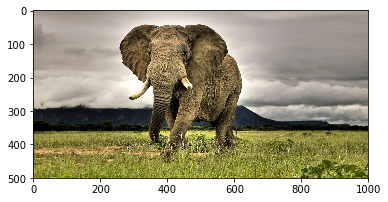

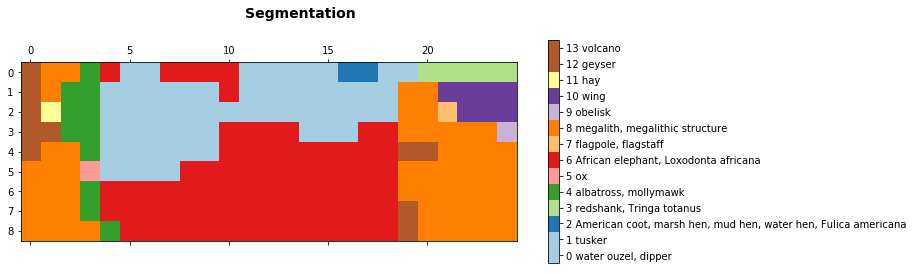

In [38]:
# Show the downloaded image
plt.imshow(test_image)
discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")